In [1]:
import pyreadr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv(r"G:\Spring2022\CS 415\Final Project\Abalone\abalone.csv")

In [66]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    blanks = ['' for i in range(cf.size)]
    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks
    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))
        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')
    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

<Figure size 720x432 with 0 Axes>

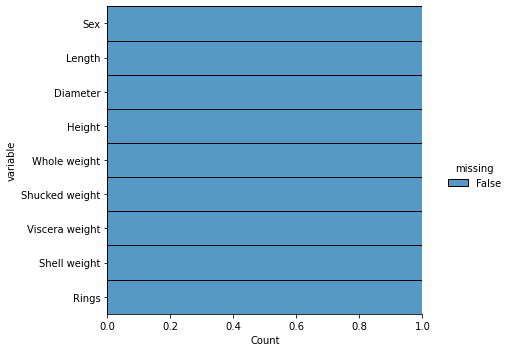

In [2]:
plt.figure(figsize=(10,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
# No missing data

In [3]:
df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


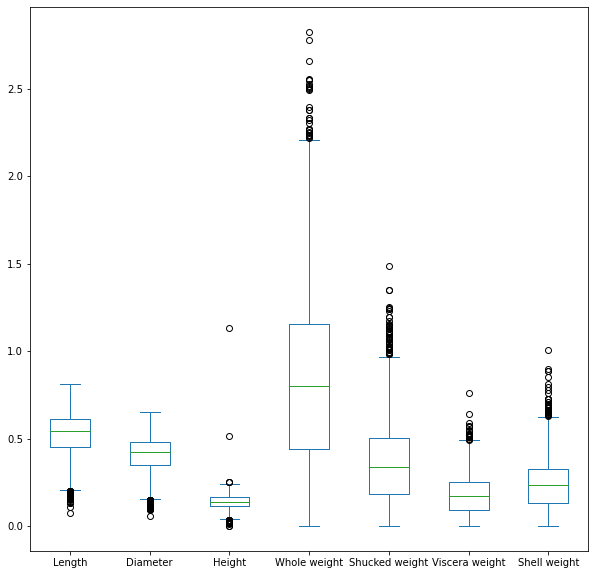

In [5]:
no_ring = df.drop(['Rings'], axis=1)
no_ring.plot.box(figsize=(10,10));

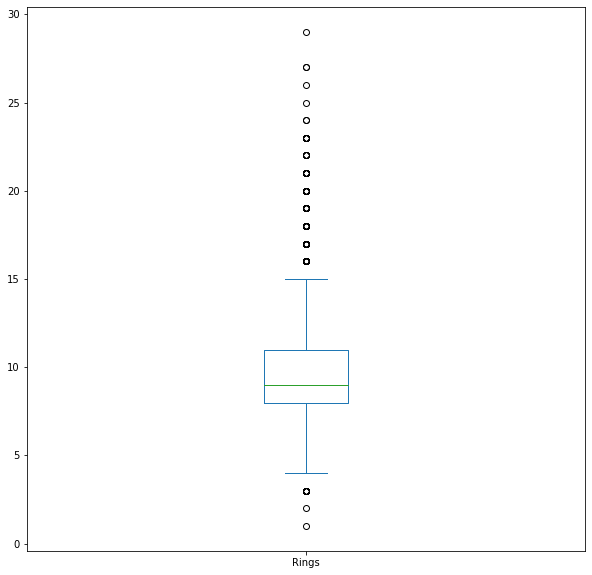

In [6]:
ring = df['Rings']
ring.plot.box(figsize=(10,10));

M    1528
I    1342
F    1307
Name: Sex, dtype: int64


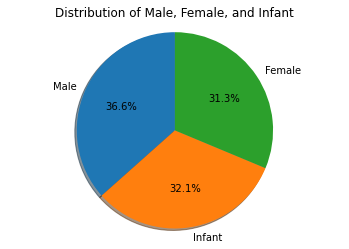

In [7]:
print(df['Sex'].value_counts())

plt.pie(df['Sex'].value_counts(), labels=['Male', 'Infant', 'Female'], 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Distribution of Male, Female, and Infant')
plt.axis('equal')
plt.show()

In [8]:
ans = [y for x, y in df.groupby('Sex', as_index=False)]
ans

[     Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
 2      F   0.530     0.420   0.135        0.6770          0.2565   
 6      F   0.530     0.415   0.150        0.7775          0.2370   
 7      F   0.545     0.425   0.125        0.7680          0.2940   
 9      F   0.550     0.440   0.150        0.8945          0.3145   
 10     F   0.525     0.380   0.140        0.6065          0.1940   
 ...   ..     ...       ...     ...           ...             ...   
 4160   F   0.585     0.475   0.165        1.0530          0.4580   
 4161   F   0.585     0.455   0.170        0.9945          0.4255   
 4168   F   0.515     0.400   0.125        0.6150          0.2865   
 4172   F   0.565     0.450   0.165        0.8870          0.3700   
 4175   F   0.625     0.485   0.150        1.0945          0.5310   
 
       Viscera weight  Shell weight  Rings  
 2             0.1415        0.2100      9  
 6             0.1415        0.3300     20  
 7             0.1495        0.2600

<AxesSubplot:ylabel='Frequency'>

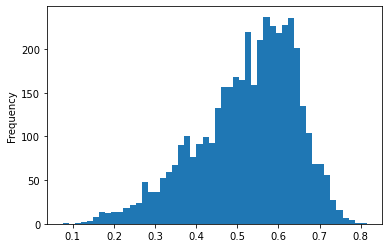

In [9]:
df['Length'].plot(kind='hist', bins=50)

<AxesSubplot:ylabel='Frequency'>

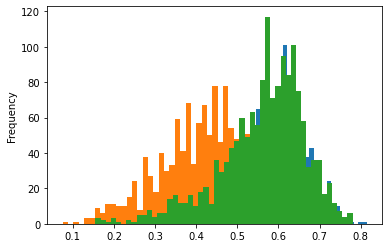

In [10]:
ans[0]['Length'].plot(kind='hist', bins=50) #Blue Female
ans[1]['Length'].plot(kind='hist', bins=50) #Orange Infant
ans[2]['Length'].plot(kind='hist', bins=50) #Green Male

<AxesSubplot:ylabel='Frequency'>

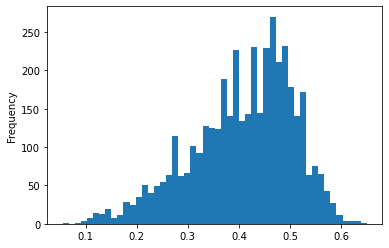

In [11]:
df['Diameter'].plot(kind='hist', bins=50)

<AxesSubplot:ylabel='Frequency'>

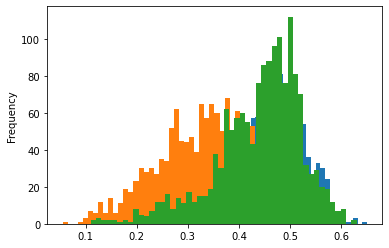

In [12]:
ans[0]['Diameter'].plot(kind='hist', bins=50) #Blue Female
ans[1]['Diameter'].plot(kind='hist', bins=50) #Orange Infant
ans[2]['Diameter'].plot(kind='hist', bins=50) #Green Male

<AxesSubplot:ylabel='Frequency'>

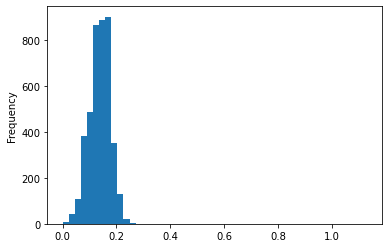

In [13]:
df['Height'].plot(kind='hist', bins=50)

<AxesSubplot:ylabel='Frequency'>

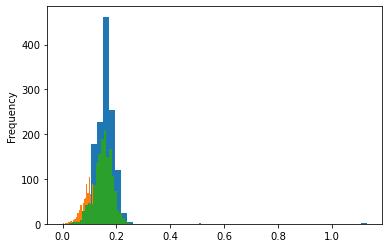

In [14]:
ans[0]['Height'].plot(kind='hist', bins=50) #Blue Female
ans[1]['Height'].plot(kind='hist', bins=50) #Orange Infant
ans[2]['Height'].plot(kind='hist', bins=50) #Green Male

<AxesSubplot:ylabel='Frequency'>

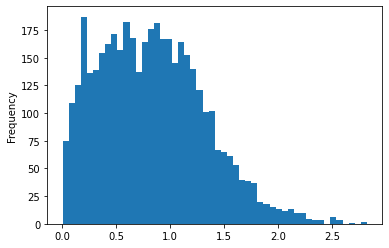

In [15]:
df['Whole weight'].plot(kind='hist', bins=50)

<AxesSubplot:ylabel='Frequency'>

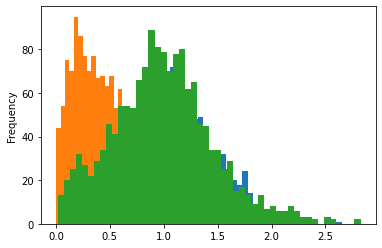

In [16]:
ans[0]['Whole weight'].plot(kind='hist', bins=50) #Blue Female
ans[1]['Whole weight'].plot(kind='hist', bins=50) #Orange Infant
ans[2]['Whole weight'].plot(kind='hist', bins=50) #Green Male

<AxesSubplot:ylabel='Frequency'>

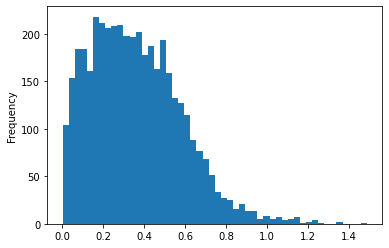

In [17]:
df['Shucked weight'].plot(kind='hist', bins=50)

<AxesSubplot:ylabel='Frequency'>

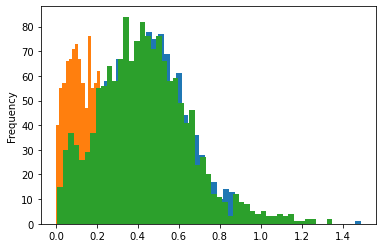

In [18]:
ans[0]['Shucked weight'].plot(kind='hist', bins=50) #Blue Female
ans[1]['Shucked weight'].plot(kind='hist', bins=50) #Orange Infant
ans[2]['Shucked weight'].plot(kind='hist', bins=50) #Green Male

<AxesSubplot:ylabel='Frequency'>

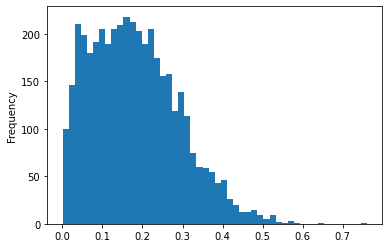

In [19]:
df['Viscera weight'].plot(kind='hist', bins=50)

<AxesSubplot:ylabel='Frequency'>

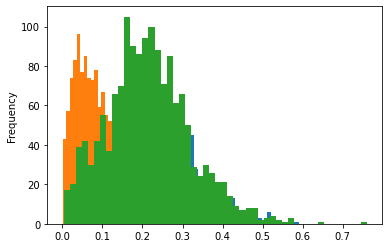

In [20]:
ans[0]['Viscera weight'].plot(kind='hist', bins=50) #Blue Female
ans[1]['Viscera weight'].plot(kind='hist', bins=50) #Orange Infant
ans[2]['Viscera weight'].plot(kind='hist', bins=50) #Green Male

<AxesSubplot:ylabel='Frequency'>

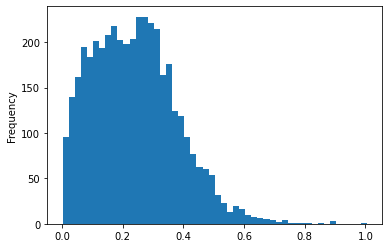

In [21]:
df['Shell weight'].plot(kind='hist', bins=50)

<AxesSubplot:ylabel='Frequency'>

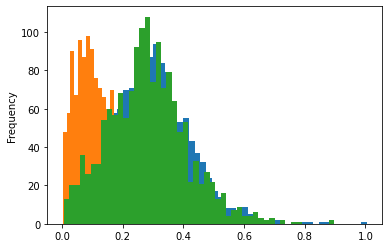

In [22]:
ans[0]['Shell weight'].plot(kind='hist', bins=50) #Blue Female
ans[1]['Shell weight'].plot(kind='hist', bins=50) #Orange Infant
ans[2]['Shell weight'].plot(kind='hist', bins=50) #Green Male

<AxesSubplot:ylabel='Frequency'>

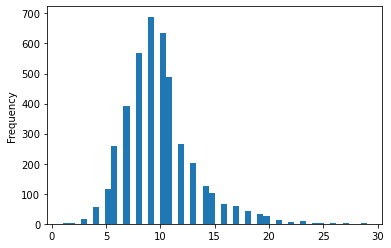

In [23]:
df['Rings'].plot(kind='hist', bins=50)

<AxesSubplot:ylabel='Frequency'>

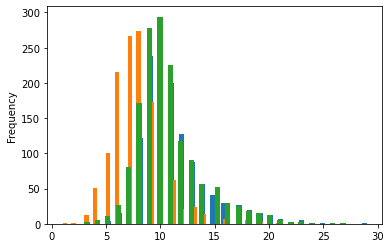

In [24]:
ans[0]['Rings'].plot(kind='hist', bins=50) #Blue Female
ans[1]['Rings'].plot(kind='hist', bins=50) #Orange Infant
ans[2]['Rings'].plot(kind='hist', bins=50) #Green Male

In [25]:
enc = LabelEncoder()

In [26]:
y = pd.DataFrame(enc.fit_transform(df['Sex']))

In [27]:
X = df.drop(['Sex'], axis=1)
# feature importance trimmed
#X = df.drop(['Sex', 'Diameter', 'Length', 'Height', 'Rings'], axis=1)

In [28]:
X

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [29]:
X = pd.DataFrame(MinMaxScaler().fit_transform(X))
X = pd.DataFrame(StandardScaler().fit_transform(X))

In [30]:
X

,0,1,2,3,4,5,6,7
0,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217,1.571544
1,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987,-0.910013
2,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139,-0.289624
3,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294,0.020571
4,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757,-0.910013
...,...,...,...,...,...,...,...,...
4172,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062,0.330765
4173,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685,0.020571
4174,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955,-0.289624
4175,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739,0.020571


In [31]:
y

,0
0,2
1,2
2,0
3,2
4,1
...,...
4172,0
4173,2
4174,2
4175,0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
#= LogisticRegression()
#= DecisionTreeClassifier()
#= MLPClassifier(random_state=1, max_iter=300)
# SVC()
#OneVsRestClassifier(estimator=SVC())
# RandomForestClassifier()

In [34]:
lr = LogisticRegression().fit(X_train, y_train.values.ravel())
lr_predict_test = lr.predict(X_test)
lr_predict_train = lr.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), lr_predict_test))
print(classification_report(y_test.values.ravel(), lr_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), lr_predict_train))
print(classification_report(y_train.values.ravel(), lr_predict_train))


Test accuracy:  0.583732057416268
              precision    recall  f1-score   support

           0       0.50      0.38      0.43       262
           1       0.69      0.87      0.76       267
           2       0.52      0.51      0.52       307

    accuracy                           0.58       836
   macro avg       0.57      0.59      0.57       836
weighted avg       0.57      0.58      0.57       836

Train accuracy:  0.556420233463035
              precision    recall  f1-score   support

           0       0.49      0.37      0.42      1045
           1       0.66      0.82      0.73      1075
           2       0.49      0.49      0.49      1221

    accuracy                           0.56      3341
   macro avg       0.54      0.56      0.55      3341
weighted avg       0.54      0.56      0.54      3341



In [35]:
ovrlr = OneVsRestClassifier(estimator=LogisticRegression()).fit(X_train, y_train)
ovrlr_predict_test = ovrlr.predict(X_test)
ovrlr_predict_train= ovrlr.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test, ovrlr_predict_test))
print(classification_report(y_test, ovrlr_predict_test))
print("Train accuracy: ", accuracy_score(y_train, ovrlr_predict_train))
print(classification_report(y_train, ovrlr_predict_train))

Test accuracy:  0.5729665071770335
              precision    recall  f1-score   support

           0       0.48      0.40      0.44       262
           1       0.68      0.87      0.76       267
           2       0.52      0.46      0.49       307

    accuracy                           0.57       836
   macro avg       0.56      0.58      0.56       836
weighted avg       0.56      0.57      0.56       836

Train accuracy:  0.5534271176294523
              precision    recall  f1-score   support

           0       0.48      0.38      0.43      1045
           1       0.64      0.82      0.72      1075
           2       0.50      0.46      0.48      1221

    accuracy                           0.55      3341
   macro avg       0.54      0.56      0.54      3341
weighted avg       0.54      0.55      0.54      3341



In [36]:
ovolr = OneVsOneClassifier(estimator=LogisticRegression()).fit(X_train, y_train.values.ravel())
ovolr_predict_test = ovolr.predict(X_test)
ovolr_predict_train= ovolr.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), ovolr_predict_test))
print(classification_report(y_test.values.ravel(), ovolr_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), ovolr_predict_train))
print(classification_report(y_train.values.ravel(), ovolr_predict_train))

Test accuracy:  0.5825358851674641
              precision    recall  f1-score   support

           0       0.50      0.40      0.44       262
           1       0.69      0.87      0.77       267
           2       0.52      0.50      0.51       307

    accuracy                           0.58       836
   macro avg       0.57      0.59      0.57       836
weighted avg       0.57      0.58      0.57       836

Train accuracy:  0.5558216102963185
              precision    recall  f1-score   support

           0       0.49      0.38      0.43      1045
           1       0.65      0.81      0.72      1075
           2       0.49      0.48      0.49      1221

    accuracy                           0.56      3341
   macro avg       0.54      0.56      0.55      3341
weighted avg       0.54      0.56      0.54      3341



In [37]:
trc = DecisionTreeClassifier().fit(X_train, y_train)
trc_predict_test = trc.predict(X_test)
trc_predict_train = trc.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test, trc_predict_test))
print(classification_report(y_test, trc_predict_test))
print("Train accuracy: ", accuracy_score(y_train, trc_predict_train))
print(classification_report(y_train, trc_predict_train))

Test accuracy:  0.49282296650717705
              precision    recall  f1-score   support

           0       0.39      0.40      0.39       262
           1       0.66      0.63      0.65       267
           2       0.45      0.45      0.45       307

    accuracy                           0.49       836
   macro avg       0.50      0.49      0.50       836
weighted avg       0.50      0.49      0.49       836

Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00      1075
           2       1.00      1.00      1.00      1221

    accuracy                           1.00      3341
   macro avg       1.00      1.00      1.00      3341
weighted avg       1.00      1.00      1.00      3341



In [38]:
ovrtrc = OneVsRestClassifier(estimator=DecisionTreeClassifier()).fit(X_train, y_train)
ovrtrc_predict_test = ovrtrc.predict(X_test)
ovrtrc_predict_train= ovrtrc.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test, ovrtrc_predict_test))
print(classification_report(y_test, ovrtrc_predict_test))
print("Train accuracy: ", accuracy_score(y_train, ovrtrc_predict_train))
print(classification_report(y_train, ovrtrc_predict_train))

Test accuracy:  0.5
              precision    recall  f1-score   support

           0       0.41      0.23      0.29       262
           1       0.72      0.57      0.63       267
           2       0.43      0.67      0.53       307

    accuracy                           0.50       836
   macro avg       0.52      0.49      0.48       836
weighted avg       0.52      0.50      0.49       836

Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00      1075
           2       1.00      1.00      1.00      1221

    accuracy                           1.00      3341
   macro avg       1.00      1.00      1.00      3341
weighted avg       1.00      1.00      1.00      3341



In [39]:
ovotrc = OneVsOneClassifier(estimator=DecisionTreeClassifier()).fit(X_train, y_train.values.ravel())
ovotrc_predict_test = ovotrc.predict(X_test)
ovotrc_predict_train= ovotrc.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), ovotrc_predict_test))
print(classification_report(y_test.values.ravel(), ovotrc_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), ovotrc_predict_train))
print(classification_report(y_train.values.ravel(), ovotrc_predict_train))

Test accuracy:  0.5191387559808612
              precision    recall  f1-score   support

           0       0.47      0.40      0.43       262
           1       0.68      0.59      0.63       267
           2       0.45      0.56      0.50       307

    accuracy                           0.52       836
   macro avg       0.53      0.52      0.52       836
weighted avg       0.53      0.52      0.52       836

Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00      1075
           2       1.00      1.00      1.00      1221

    accuracy                           1.00      3341
   macro avg       1.00      1.00      1.00      3341
weighted avg       1.00      1.00      1.00      3341



In [109]:
trr = DecisionTreeRegressor().fit(X_train, y_train)
trr_predict_test = trr.predict(X_test)
trr_predict_train = trr.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test, trr_predict_test))
print(classification_report(y_test, trr_predict_test))
print("Train accuracy: ", accuracy_score(y_train, trr_predict_train))
print(classification_report(y_train, trr_predict_train))

Test accuracy:  0.48444976076555024
              precision    recall  f1-score   support

           0       0.42      0.45      0.43       262
           1       0.63      0.61      0.62       267
           2       0.42      0.41      0.41       307

    accuracy                           0.48       836
   macro avg       0.49      0.49      0.49       836
weighted avg       0.49      0.48      0.49       836

Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00      1075
           2       1.00      1.00      1.00      1221

    accuracy                           1.00      3341
   macro avg       1.00      1.00      1.00      3341
weighted avg       1.00      1.00      1.00      3341



In [110]:
ovrtrr = OneVsRestClassifier(estimator=DecisionTreeRegressor()).fit(X_train, y_train)
ovrtrr_predict_test = ovrtrr.predict(X_test)
ovrtrr_predict_train= ovrtrr.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test, ovrtrr_predict_test))
print(classification_report(y_test, ovrtrr_predict_test))
print("Train accuracy: ", accuracy_score(y_train, ovrtrr_predict_train))
print(classification_report(y_train, ovrtrr_predict_train))

Test accuracy:  0.5047846889952153
              precision    recall  f1-score   support

           0       0.41      0.23      0.29       262
           1       0.71      0.56      0.63       267
           2       0.44      0.69      0.54       307

    accuracy                           0.50       836
   macro avg       0.52      0.49      0.49       836
weighted avg       0.52      0.50      0.49       836

Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00      1075
           2       1.00      1.00      1.00      1221

    accuracy                           1.00      3341
   macro avg       1.00      1.00      1.00      3341
weighted avg       1.00      1.00      1.00      3341



In [111]:
ovotrr = OneVsOneClassifier(estimator=DecisionTreeRegressor()).fit(X_train, y_train.values.ravel())
ovotrr_predict_test = ovotrr.predict(X_test)
ovotrr_predict_train= ovotrr.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), ovotrr_predict_test))
print(classification_report(y_test.values.ravel(), ovotrr_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), ovotrr_predict_train))
print(classification_report(y_train.values.ravel(), ovotrr_predict_train))

Test accuracy:  0.5107655502392344
              precision    recall  f1-score   support

           0       0.45      0.39      0.42       262
           1       0.69      0.60      0.64       267
           2       0.44      0.53      0.48       307

    accuracy                           0.51       836
   macro avg       0.52      0.51      0.51       836
weighted avg       0.52      0.51      0.51       836

Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00      1075
           2       1.00      1.00      1.00      1221

    accuracy                           1.00      3341
   macro avg       1.00      1.00      1.00      3341
weighted avg       1.00      1.00      1.00      3341



In [40]:
mlp = MLPClassifier(random_state=1, max_iter=500).fit(X_train, y_train.values.ravel())
mlp_predict_test = mlp.predict(X_test)
mlp_predict_train= mlp.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), mlp_predict_test))
print(classification_report(y_test.values.ravel(), mlp_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), mlp_predict_train))
print(classification_report(y_train.values.ravel(), mlp_predict_train))

Test accuracy:  0.5801435406698564
              precision    recall  f1-score   support

           0       0.49      0.35      0.41       262
           1       0.73      0.84      0.78       267
           2       0.50      0.55      0.52       307

    accuracy                           0.58       836
   macro avg       0.57      0.58      0.57       836
weighted avg       0.57      0.58      0.57       836

Train accuracy:  0.6022149057168512
              precision    recall  f1-score   support

           0       0.55      0.39      0.45      1045
           1       0.71      0.81      0.76      1075
           2       0.53      0.61      0.57      1221

    accuracy                           0.60      3341
   macro avg       0.60      0.60      0.59      3341
weighted avg       0.60      0.60      0.59      3341



In [41]:
ovrmlp = OneVsRestClassifier(estimator=MLPClassifier(random_state=1, max_iter=500)).fit(X_train, y_train)
ovrmlp_predict_test = ovrmlp.predict(X_test)
ovrmlp_predict_train= ovrmlp.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test, ovrmlp_predict_test))
print(classification_report(y_test, ovrmlp_predict_test))
print("Train accuracy: ", accuracy_score(y_train, ovrmlp_predict_train))
print(classification_report(y_train, ovrmlp_predict_train))

Test accuracy:  0.5813397129186603
              precision    recall  f1-score   support

           0       0.50      0.40      0.45       262
           1       0.73      0.84      0.78       267
           2       0.50      0.51      0.50       307

    accuracy                           0.58       836
   macro avg       0.57      0.58      0.58       836
weighted avg       0.57      0.58      0.57       836

Train accuracy:  0.6055073331337922
              precision    recall  f1-score   support

           0       0.55      0.44      0.49      1045
           1       0.71      0.80      0.76      1075
           2       0.54      0.57      0.56      1221

    accuracy                           0.61      3341
   macro avg       0.60      0.61      0.60      3341
weighted avg       0.60      0.61      0.60      3341



In [42]:
ovomlp = OneVsOneClassifier(estimator=MLPClassifier(random_state=1, max_iter=500)).fit(X_train, y_train.values.ravel())
ovomlp_predict_test = ovomlp.predict(X_test)
ovomlp_predict_train= ovomlp.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), ovomlp_predict_test))
print(classification_report(y_test.values.ravel(), ovomlp_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), ovomlp_predict_train))
print(classification_report(y_train.values.ravel(), ovomlp_predict_train))

Test accuracy:  0.5777511961722488
              precision    recall  f1-score   support

           0       0.49      0.43      0.46       262
           1       0.74      0.83      0.78       267
           2       0.49      0.49      0.49       307

    accuracy                           0.58       836
   macro avg       0.57      0.58      0.57       836
weighted avg       0.57      0.58      0.57       836

Train accuracy:  0.6013169709667764
              precision    recall  f1-score   support

           0       0.54      0.47      0.50      1045
           1       0.72      0.79      0.75      1075
           2       0.54      0.55      0.54      1221

    accuracy                           0.60      3341
   macro avg       0.60      0.60      0.60      3341
weighted avg       0.60      0.60      0.60      3341



In [43]:
rfst = RandomForestClassifier().fit(X_train, y_train.values.ravel())
rfst_predict_test = rfst.predict(X_test)
rfst_predict_train= rfst.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), rfst_predict_test))
print(classification_report(y_test.values.ravel(), rfst_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), rfst_predict_train))
print(classification_report(y_train.values.ravel(), rfst_predict_train))

Test accuracy:  0.5550239234449761
              precision    recall  f1-score   support

           0       0.45      0.40      0.42       262
           1       0.73      0.79      0.76       267
           2       0.47      0.49      0.48       307

    accuracy                           0.56       836
   macro avg       0.55      0.56      0.55       836
weighted avg       0.55      0.56      0.55       836

Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00      1075
           2       1.00      1.00      1.00      1221

    accuracy                           1.00      3341
   macro avg       1.00      1.00      1.00      3341
weighted avg       1.00      1.00      1.00      3341



In [44]:
ovrrfs = OneVsRestClassifier(estimator=RandomForestClassifier()).fit(X_train, y_train)
ovrrfs_predict_test = ovrrfs.predict(X_test)
ovrrfs_predict_train= ovrrfs.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test, ovrrfs_predict_test))
print(classification_report(y_test, ovrrfs_predict_test))
print("Train accuracy: ", accuracy_score(y_train, ovrrfs_predict_train))
print(classification_report(y_train, ovrrfs_predict_train))

Test accuracy:  0.5490430622009569
              precision    recall  f1-score   support

           0       0.44      0.35      0.39       262
           1       0.73      0.76      0.74       267
           2       0.47      0.53      0.50       307

    accuracy                           0.55       836
   macro avg       0.55      0.55      0.55       836
weighted avg       0.54      0.55      0.54       836

Train accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00      1075
           2       1.00      1.00      1.00      1221

    accuracy                           1.00      3341
   macro avg       1.00      1.00      1.00      3341
weighted avg       1.00      1.00      1.00      3341



In [45]:
ovorfs = OneVsOneClassifier(estimator=RandomForestClassifier()).fit(X_train, y_train.values.ravel())
ovorfs_predict_test = ovorfs.predict(X_test)
ovorfs_predict_train= ovorfs.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), ovorfs_predict_test))
print(classification_report(y_test.values.ravel(), ovorfs_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), ovorfs_predict_train))
print(classification_report(y_train.values.ravel(), ovorfs_predict_train))

Test accuracy:  0.5394736842105263
              precision    recall  f1-score   support

           0       0.41      0.37      0.39       262
           1       0.75      0.76      0.76       267
           2       0.46      0.50      0.48       307

    accuracy                           0.54       836
   macro avg       0.54      0.54      0.54       836
weighted avg       0.54      0.54      0.54       836

Train accuracy:  0.9997006884166417
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00      1075
           2       1.00      1.00      1.00      1221

    accuracy                           1.00      3341
   macro avg       1.00      1.00      1.00      3341
weighted avg       1.00      1.00      1.00      3341



In [46]:
sgd = SGDClassifier().fit(X_train, y_train.values.ravel())
sgd_predict_test = sgd.predict(X_test)
sgd_predict_train= sgd.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), sgd_predict_test))
print(classification_report(y_test.values.ravel(), sgd_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), sgd_predict_train))
print(classification_report(y_train.values.ravel(), sgd_predict_train))

Test accuracy:  0.5717703349282297
              precision    recall  f1-score   support

           0       0.48      0.26      0.34       262
           1       0.66      0.90      0.76       267
           2       0.51      0.56      0.53       307

    accuracy                           0.57       836
   macro avg       0.55      0.57      0.54       836
weighted avg       0.55      0.57      0.54       836

Train accuracy:  0.5489374438790782
              precision    recall  f1-score   support

           0       0.48      0.25      0.33      1045
           1       0.62      0.85      0.72      1075
           2       0.50      0.54      0.52      1221

    accuracy                           0.55      3341
   macro avg       0.53      0.55      0.52      3341
weighted avg       0.53      0.55      0.52      3341



In [47]:
ovrsdg = OneVsRestClassifier(estimator=SGDClassifier()).fit(X_train, y_train)
ovrsdg_predict_test = ovrsdg .predict(X_test)
ovrsdg_predict_train= ovrsdg .predict(X_train)
print("Test accuracy: ", accuracy_score(y_test, ovrsdg_predict_test))
print(classification_report(y_test, ovrsdg_predict_test))
print("Train accuracy: ", accuracy_score(y_train, ovrsdg_predict_train))
print(classification_report(y_train, ovrsdg_predict_train))

Test accuracy:  0.55622009569378
              precision    recall  f1-score   support

           0       0.46      0.39      0.42       262
           1       0.68      0.86      0.76       267
           2       0.49      0.44      0.46       307

    accuracy                           0.56       836
   macro avg       0.54      0.56      0.55       836
weighted avg       0.54      0.56      0.54       836

Train accuracy:  0.5507333133792278
              precision    recall  f1-score   support

           0       0.48      0.39      0.43      1045
           1       0.63      0.82      0.72      1075
           2       0.50      0.45      0.47      1221

    accuracy                           0.55      3341
   macro avg       0.54      0.55      0.54      3341
weighted avg       0.54      0.55      0.54      3341



In [48]:
ovosdg = OneVsOneClassifier(estimator=SGDClassifier()).fit(X_train, y_train.values.ravel())
ovosdg_predict_test = ovosdg.predict(X_test)
ovosdg_predict_train= ovosdg.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), ovosdg_predict_test))
print(classification_report(y_test.values.ravel(), ovosdg_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), ovosdg_predict_train))
print(classification_report(y_train.values.ravel(), ovosdg_predict_train))

Test accuracy:  0.5598086124401914
              precision    recall  f1-score   support

           0       0.60      0.02      0.04       262
           1       0.64      0.89      0.74       267
           2       0.49      0.73      0.59       307

    accuracy                           0.56       836
   macro avg       0.58      0.55      0.46       836
weighted avg       0.57      0.56      0.47       836

Train accuracy:  0.5411553427117629
              precision    recall  f1-score   support

           0       0.54      0.02      0.05      1045
           1       0.61      0.85      0.71      1075
           2       0.49      0.71      0.58      1221

    accuracy                           0.54      3341
   macro avg       0.54      0.53      0.44      3341
weighted avg       0.54      0.54      0.45      3341



In [49]:
rdg = RidgeClassifier().fit(X_train, y_train.values.ravel())
rdg_predict_test = rdg.predict(X_test)
rdg_predict_train= rdg.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), rdg_predict_test))
print(classification_report(y_test.values.ravel(), rdg_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), rdg_predict_train))
print(classification_report(y_train.values.ravel(), rdg_predict_train))

Test accuracy:  0.5633971291866029
              precision    recall  f1-score   support

           0       0.47      0.39      0.42       262
           1       0.65      0.89      0.75       267
           2       0.51      0.43      0.47       307

    accuracy                           0.56       836
   macro avg       0.55      0.57      0.55       836
weighted avg       0.54      0.56      0.55       836

Train accuracy:  0.5471415743789285
              precision    recall  f1-score   support

           0       0.49      0.37      0.42      1045
           1       0.61      0.83      0.71      1075
           2       0.50      0.45      0.48      1221

    accuracy                           0.55      3341
   macro avg       0.53      0.55      0.53      3341
weighted avg       0.53      0.55      0.53      3341



In [50]:
ovrrdg = OneVsRestClassifier(estimator=RidgeClassifier()).fit(X_train, y_train)
ovrrdg_predict_test = ovrrdg.predict(X_test)
ovrrdg_predict_train= ovrrdg.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test, ovrrdg_predict_test))
print(classification_report(y_test, ovrrdg_predict_test))
print("Train accuracy: ", accuracy_score(y_train, ovrrdg_predict_train))
print(classification_report(y_train, ovrrdg_predict_train))

Test accuracy:  0.5633971291866029
              precision    recall  f1-score   support

           0       0.47      0.39      0.42       262
           1       0.65      0.89      0.75       267
           2       0.51      0.43      0.47       307

    accuracy                           0.56       836
   macro avg       0.55      0.57      0.55       836
weighted avg       0.54      0.56      0.55       836

Train accuracy:  0.5471415743789285
              precision    recall  f1-score   support

           0       0.49      0.37      0.42      1045
           1       0.61      0.83      0.71      1075
           2       0.50      0.45      0.48      1221

    accuracy                           0.55      3341
   macro avg       0.53      0.55      0.53      3341
weighted avg       0.53      0.55      0.53      3341



In [51]:
ovordg = OneVsOneClassifier(estimator=RidgeClassifier()).fit(X_train, y_train.values.ravel())
ovordg_predict_test = ovordg.predict(X_test)
ovordg_predict_train= ovordg.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), ovordg_predict_test))
print(classification_report(y_test.values.ravel(), ovordg_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), ovordg_predict_train))
print(classification_report(y_train.values.ravel(), ovordg_predict_train))

Test accuracy:  0.5717703349282297
              precision    recall  f1-score   support

           0       0.50      0.40      0.44       262
           1       0.68      0.85      0.75       267
           2       0.50      0.48      0.49       307

    accuracy                           0.57       836
   macro avg       0.56      0.58      0.56       836
weighted avg       0.56      0.57      0.56       836

Train accuracy:  0.5528284944627357
              precision    recall  f1-score   support

           0       0.49      0.38      0.43      1045
           1       0.65      0.80      0.72      1075
           2       0.49      0.48      0.49      1221

    accuracy                           0.55      3341
   macro avg       0.54      0.55      0.54      3341
weighted avg       0.54      0.55      0.54      3341



In [52]:
ovr = OneVsRestClassifier(estimator=SVC()).fit(X_train, y_train)
ovr_predict_test = ovr.predict(X_test)
ovr_predict_train= ovr.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test, ovr_predict_test))
print(classification_report(y_test, ovr_predict_test))
print("Train accuracy: ", accuracy_score(y_train, ovr_predict_train))
print(classification_report(y_train, ovr_predict_train))

Test accuracy:  0.5729665071770335
              precision    recall  f1-score   support

           0       0.51      0.34      0.40       262
           1       0.65      0.90      0.76       267
           2       0.51      0.50      0.50       307

    accuracy                           0.57       836
   macro avg       0.56      0.58      0.55       836
weighted avg       0.56      0.57      0.55       836

Train accuracy:  0.5776713558814726
              precision    recall  f1-score   support

           0       0.55      0.36      0.43      1045
           1       0.64      0.86      0.73      1075
           2       0.52      0.52      0.52      1221

    accuracy                           0.58      3341
   macro avg       0.57      0.58      0.56      3341
weighted avg       0.57      0.58      0.56      3341



In [53]:
ovo = OneVsOneClassifier(estimator=SVC()).fit(X_train, y_train.values.ravel())
ovo_predict_test = ovo.predict(X_test)
ovo_predict_train= ovo.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), ovo_predict_test))
print(classification_report(y_test.values.ravel(), ovo_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), ovo_predict_train))
print(classification_report(y_train.values.ravel(), ovo_predict_train))

Test accuracy:  0.5765550239234449
              precision    recall  f1-score   support

           0       0.51      0.31      0.39       262
           1       0.71      0.83      0.76       267
           2       0.49      0.58      0.53       307

    accuracy                           0.58       836
   macro avg       0.57      0.57      0.56       836
weighted avg       0.57      0.58      0.56       836

Train accuracy:  0.5782699790481892
              precision    recall  f1-score   support

           0       0.55      0.31      0.40      1045
           1       0.69      0.79      0.73      1075
           2       0.50      0.62      0.55      1221

    accuracy                           0.58      3341
   macro avg       0.58      0.57      0.56      3341
weighted avg       0.58      0.58      0.56      3341



In [54]:
rbf = SVC(kernel='rbf').fit(X_train, y_train.values.ravel())
rbf_predict_test = rbf.predict(X_test)
rbf_predict_train= rbf.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), rbf_predict_test))
print(classification_report(y_test.values.ravel(), rbf_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), rbf_predict_train))
print(classification_report(y_train.values.ravel(), rbf_predict_train))

Test accuracy:  0.5669856459330144
              precision    recall  f1-score   support

           0       0.49      0.29      0.36       262
           1       0.71      0.83      0.76       267
           2       0.48      0.58      0.53       307

    accuracy                           0.57       836
   macro avg       0.56      0.56      0.55       836
weighted avg       0.56      0.57      0.55       836

Train accuracy:  0.5785692906315475
              precision    recall  f1-score   support

           0       0.56      0.30      0.39      1045
           1       0.69      0.79      0.73      1075
           2       0.50      0.64      0.56      1221

    accuracy                           0.58      3341
   macro avg       0.58      0.57      0.56      3341
weighted avg       0.58      0.58      0.56      3341



In [55]:
poly = SVC(kernel='poly').fit(X_train, y_train.values.ravel())
poly_predict_test = poly.predict(X_test)
poly_predict_train= poly.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), poly_predict_test))
print(classification_report(y_test.values.ravel(), poly_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), poly_predict_train))
print(classification_report(y_train.values.ravel(), poly_predict_train))

Test accuracy:  0.5299043062200957
              precision    recall  f1-score   support

           0       0.65      0.05      0.09       262
           1       0.79      0.58      0.67       267
           2       0.44      0.90      0.59       307

    accuracy                           0.53       836
   macro avg       0.63      0.51      0.45       836
weighted avg       0.62      0.53      0.46       836

Train accuracy:  0.5163124812930261
              precision    recall  f1-score   support

           0       0.61      0.03      0.06      1045
           1       0.79      0.56      0.66      1075
           2       0.43      0.89      0.58      1221

    accuracy                           0.52      3341
   macro avg       0.61      0.49      0.43      3341
weighted avg       0.60      0.52      0.44      3341



In [56]:
sig = SVC(kernel='sigmoid').fit(X_train, y_train.values.ravel())
sig_predict_test = sig.predict(X_test)
sig_predict_train= sig.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), sig_predict_test))
print(classification_report(y_test.values.ravel(), sig_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), sig_predict_train))
print(classification_report(y_train.values.ravel(), sig_predict_train))

Test accuracy:  0.4880382775119617
              precision    recall  f1-score   support

           0       0.51      0.29      0.37       262
           1       0.54      0.67      0.60       267
           2       0.43      0.50      0.46       307

    accuracy                           0.49       836
   macro avg       0.49      0.49      0.48       836
weighted avg       0.49      0.49      0.48       836

Train accuracy:  0.4645315773720443
              precision    recall  f1-score   support

           0       0.48      0.25      0.33      1045
           1       0.51      0.65      0.57      1075
           2       0.42      0.49      0.45      1221

    accuracy                           0.46      3341
   macro avg       0.47      0.46      0.45      3341
weighted avg       0.47      0.46      0.45      3341



In [57]:
lin = SVC(kernel='linear').fit(X_train, y_train.values.ravel())
lin_predict_test = lin.predict(X_test)
lin_predict_train= lin.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), lin_predict_test))
print(classification_report(y_test.values.ravel(), lin_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), lin_predict_train))
print(classification_report(y_train.values.ravel(), lin_predict_train))

Test accuracy:  0.5849282296650717
              precision    recall  f1-score   support

           0       0.53      0.27      0.36       262
           1       0.68      0.88      0.77       267
           2       0.51      0.60      0.55       307

    accuracy                           0.58       836
   macro avg       0.57      0.58      0.56       836
weighted avg       0.57      0.58      0.56       836

Train accuracy:  0.5546243639628854
              precision    recall  f1-score   support

           0       0.51      0.28      0.36      1045
           1       0.65      0.82      0.73      1075
           2       0.48      0.56      0.52      1221

    accuracy                           0.55      3341
   macro avg       0.55      0.55      0.53      3341
weighted avg       0.54      0.55      0.53      3341



In [104]:
rbf_svc_param_grid = {
            'C': [75],
            'gamma': [0.01],
            'kernel': ['rbf'],
            'shrinking': [True], #  default
            'probability': [True], # not default
            'decision_function_shape': ['ovo'], # not default
            }

poly_svc_param_grid = {
            'C': [1],
            'degree': [1], # 3 default
            'gamma': [100],
            'kernel': ['poly'],
            'shrinking': [True], #  default
            'probability': [True], # not default
            'decision_function_shape': ['ovo'], # not default
            }

ln_svc_param_grid = {
            'C': [100],
            'kernel': ['linear'],
            'shrinking': [True], #  default
            'probability': [True], # not default
            'decision_function_shape': ['ovo'],
            }

lr_param_grid = {
            'penalty': ['l1'], #default=’l2’
            'C': [10], #default=1.0
            'fit_intercept': [True], #default=True
            'solver': ['saga'],# default=’lbfgs’
            'multi_class': ['auto'], #default=’auto’
            'max_iter': [2000],
             }
 
rfs_param_grid = {
            'n_estimators': [100], # default 100
            'criterion': ['gini'], # default gini
            'max_depth': [8], # default none
            'min_samples_split': [2], # default 2
            'min_samples_leaf': [3], # default 1
            'max_features': ['auto'], # default auto
            'max_leaf_nodes': [None], # default none
            'bootstrap': [True], # default true
            'oob_score': [True], # default false
            #'n_jobs': [5, 6, 7, 8], # default none
            #'max_samples': [6, 7, 8, 9], # default none, bootstrap=true
            }

mlp_param_grid = {
            'hidden_layer_sizes': [(100,)],
            'max_iter': [500], # default 100
            'random_state': [1], # default gini
            'activation': ['relu'], # default relu
            'solver': ['adam'], # default adam
            'alpha': [0.0001], # default 0.0001
            'batch_size': ['auto'], # default auto
            'learning_rate': ['constant'], # default constant no effects
            'learning_rate_init': [0.001], # default 0.001
            'shuffle': [False], # default True
            'tol': [0.0001], # default 0.0001
            'warm_start': [False], # default False
            'early_stopping': [False], # default False
            'beta_1': [ 0.9], # default 0.9
            'beta_2': [0.999], # default 0.999
            'n_iter_no_change': [9], #default 10
            }

rgd_param_grid = {
            'alpha': [1], #default 1.0
            'fit_intercept': [True], # default True
            'copy_X': [True], # default True
            'max_iter': [None], # default None
            'tol': [0.001], # default 0.001
            'class_weight': [None], # default None
            'solver': ['auto'], # default auto
            # 'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'
            'positive': [False], # default False
            }

ov_param_grid = {
            'estimator__hidden_layer_sizes': [(100,)],
            'estimator__max_iter': [500], # default 100
            'estimator__random_state': [1], # default gini
            'estimator__activation': ['relu'], # default relu
            'estimator__solver': ['adam'], # default adam
            'estimator__alpha': [0.0001], # default 0.0001
            'estimator__batch_size': ['auto'], # default auto
            'estimator__learning_rate': ['constant'], # default constant no effects
            'estimator__learning_rate_init': [0.001], # default 0.001
            'estimator__shuffle': [False], # default True
            'estimator__tol': [0.0001], # default 0.0001
            'estimator__warm_start': [False], # default False
            'estimator__early_stopping': [False], # default False
            'estimator__beta_1': [ 0.9], # default 0.9
            'estimator__beta_2': [0.999], # default 0.999
            'estimator__n_iter_no_change': [9], #default 10
            }

#grid = GridSearchCV(RidgeClassifier(), rgd_param_grid, cv=5, refit = True, verbose = 3)
#grid = GridSearchCV(MLPClassifier(), mlp_param_grid, cv=5, refit = True, verbose = 3)
#grid = GridSearchCV(RandomForestClassifier(), rfs_param_grid, cv=5, refit = True, verbose = 3)
grid = GridSearchCV(SVC(), rbf_svc_param_grid, cv=5, refit = True, verbose = 3)
#grid = GridSearchCV(OneVsRestClassifier(estimator=MLPClassifier()), ov_param_grid, cv=5, refit = True, verbose = 3)
#grid = GridSearchCV(OneVsOneClassifier(estimator=MLPClassifier()), ov_param_grid, cv=5, refit = True, verbose = 3)
#grid = GridSearchCV(LogisticRegression(), lr_param_grid, cv=5, refit = True, verbose = 1)


 
# fitting the model for grid search
grid.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=75, decision_function_shape=ovo, gamma=0.01, kernel=rbf, probability=True, shrinking=True;, score=0.550 total time=   2.0s
[CV 2/5] END C=75, decision_function_shape=ovo, gamma=0.01, kernel=rbf, probability=True, shrinking=True;, score=0.573 total time=   2.0s
[CV 3/5] END C=75, decision_function_shape=ovo, gamma=0.01, kernel=rbf, probability=True, shrinking=True;, score=0.587 total time=   2.1s
[CV 4/5] END C=75, decision_function_shape=ovo, gamma=0.01, kernel=rbf, probability=True, shrinking=True;, score=0.551 total time=   2.1s
[CV 5/5] END C=75, decision_function_shape=ovo, gamma=0.01, kernel=rbf, probability=True, shrinking=True;, score=0.569 total time=   2.0s


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [75], 'decision_function_shape': ['ovo'],
                         'gamma': [0.01], 'kernel': ['rbf'],
                         'probability': [True], 'shrinking': [True]},
             verbose=3)

In [105]:
bestimator = grid.best_estimator_
print(bestimator)

SVC(C=75, decision_function_shape='ovo', gamma=0.01, probability=True)


In [106]:
# RANDOMFOREST & TREE ONLY
#sorted(zip(bestimator.feature_importances_, list(df.drop(['Sex'], axis=1))), reverse=True)

In [107]:
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)
bestimator_predict_test = bestimator.predict(X_test)
bestimator_predict_train= bestimator.predict(X_train)
print("Test accuracy: ", accuracy_score(y_test.values.ravel(), bestimator_predict_test))
print(classification_report(y_test.values.ravel(), bestimator_predict_test))
print("Train accuracy: ", accuracy_score(y_train.values.ravel(), bestimator_predict_train))
print(classification_report(y_train.values.ravel(), bestimator_predict_train))

Best parameters:  {'C': 75, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf', 'probability': True, 'shrinking': True}
Best score:  0.566002971635205
Test accuracy:  0.5933014354066986
              precision    recall  f1-score   support

           0       0.54      0.29      0.38       262
           1       0.72      0.86      0.78       267
           2       0.51      0.62      0.56       307

    accuracy                           0.59       836
   macro avg       0.59      0.59      0.57       836
weighted avg       0.58      0.59      0.57       836

Train accuracy:  0.5749775516312481
              precision    recall  f1-score   support

           0       0.55      0.28      0.37      1045
           1       0.69      0.80      0.74      1075
           2       0.49      0.63      0.55      1221

    accuracy                           0.57      3341
   macro avg       0.58      0.57      0.55      3341
weighted avg       0.57      0.57      0.56      3341



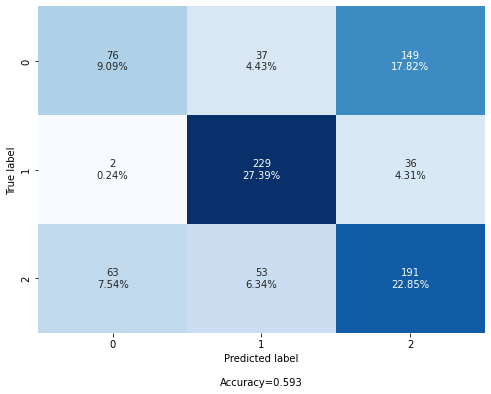

In [108]:
results = confusion_matrix(y_test.values.ravel(), bestimator_predict_test)
make_confusion_matrix(results, figsize=(8,6), cbar=False)

In [93]:
#bestimator_predictproba_test = bestimator.predict_proba(X_test)
#bestimator_predictproba_train= bestimator.predict_proba(X_train)
#print("Test probabilities: ", bestimator_predictproba_test)
#print("Train probabilities: ", bestimator_predictproba_train)

In [ ]:
#sum1 = 0.0 #female
#sum2 = 0.0 #infant
#sum3 = 0.0 #male
#divisor = 836
#for thing in bestimator_predictproba_test:
#    sum1 += thing[0]
#    sum2 += thing[1]
#    sum3 += thing[2]
#print(sum1/divisor, sum2/divisor, sum3/divisor)

In [ ]:
#sum1 = 0.0
#sum2 = 0.0
#sum3 = 0.0
#divisor = 3341
#for thing in bestimator_predictproba_train:
#    sum1 += thing[0]
#    sum2 += thing[1]
#    sum3 += thing[2]
#print(sum1/divisor, sum2/divisor, sum3/divisor)